In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use the first GPU


In [3]:
import tensorflow as tf
print("Is Built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Is Built with CUDA: True
Num GPUs Available: 1


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: tf.image.resize(img, [224, 224])
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: tf.image.resize(img, [224, 224])
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: tf.image.resize(img, [224, 224])
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.
Found 631 images belonging to 8 classes.


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [6]:
# Callbacks
checkpoint = ModelCheckpoint('best_resnet_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)


Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 2.0102 - accuracy: 0.2134
Epoch 1: val_accuracy improved from -inf to 0.23548, saving model to best_resnet_model.h5
91/91 [==============================] - 49s 443ms/step - loss: 2.0102 - accuracy: 0.2134 - val_loss: 1.8945 - val_accuracy: 0.2355
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.8736 - accuracy: 0.2639
Epoch 2: val_accuracy did not improve from 0.23548
91/91 [==============================] - 35s 381ms/step - loss: 1.8736 - accuracy: 0.2639 - val_loss: 1.8772 - val_accuracy: 0.2226
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 1.8246 - accuracy: 0.2877
Epoch 3: val_accuracy improved from 0.23548 to 0.26774, saving model to best_resnet_model.h5
91/91 [==============================] - 35s 384ms/step - loss: 1.8246 - accuracy: 0.2877 - val_loss: 1.8354 - val_accuracy: 0.2677
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 1.7771 - accuracy: 0

20/20 [==============================] - 5s 228ms/step
Accuracy: 0.3803486529318542
mAP: 0.39191900805421853


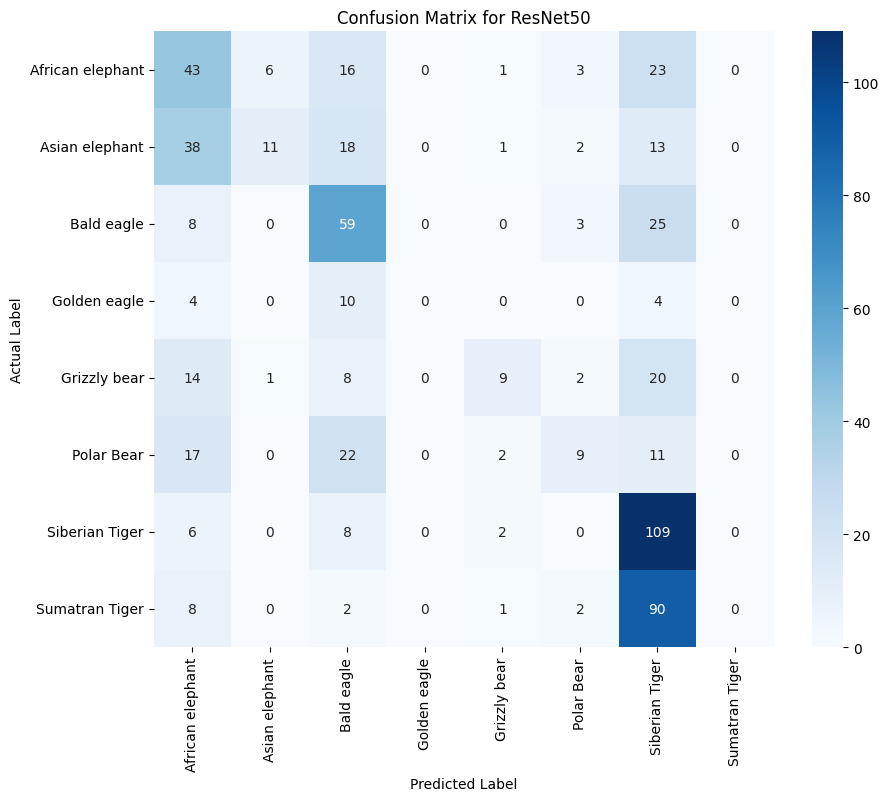

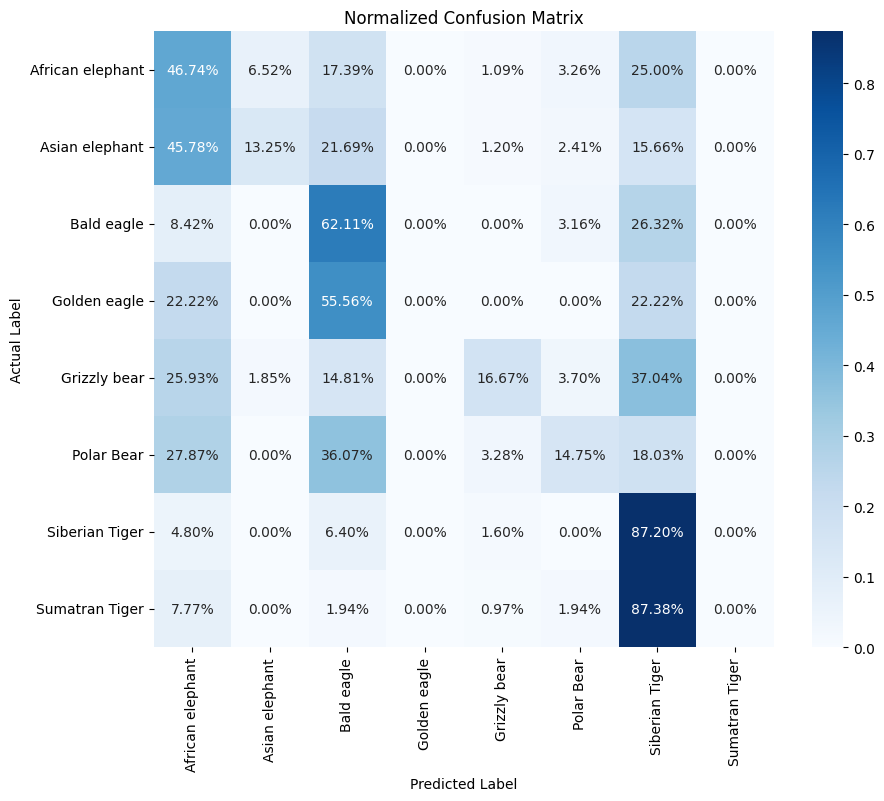

Classification Report for ResNet50
                  precision    recall  f1-score   support

African elephant       0.31      0.47      0.37        92
  Asian elephant       0.61      0.13      0.22        83
      Bald eagle       0.41      0.62      0.50        95
    Golden eagle       0.00      0.00      0.00        18
    Grizzly bear       0.56      0.17      0.26        54
      Polar Bear       0.43      0.15      0.22        61
  Siberian Tiger       0.37      0.87      0.52       125
  Sumatran Tiger       0.00      0.00      0.00       103

        accuracy                           0.38       631
       macro avg       0.34      0.30      0.26       631
    weighted avg       0.35      0.38      0.30       631



In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the best model
model = tf.keras.models.load_model('best_resnet_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(
    tf.keras.utils.to_categorical(y_true, num_classes=len(test_generator.class_indices)), y_pred
)

# Print overall metrics
print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix (raw counts)
conf_mat = confusion_matrix(y_true, y_pred_labels)

# Plot raw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Normalized Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys(), zero_division=0))


Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.
Found 631 images belonging to 8 classes.
Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 2.0188 - accuracy: 0.2099
Epoch 1: val_accuracy improved from -inf to 0.25645, saving model to best_resnet50_model.h5
91/91 [==============================] - 27s 259ms/step - loss: 2.0188 - accuracy: 0.2099 - val_loss: 1.9048 - val_accuracy: 0.2565
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.8707 - accuracy: 0.2691
Epoch 2: val_accuracy did not improve from 0.25645
91/91 [==============================] - 22s 244ms/step - loss: 1.8707 - accuracy: 0.2691 - val_loss: 1.8620 - val_accuracy: 0.2484
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 1.8303 - accuracy: 0.2729
Epoch 3: val_accuracy improved from 0.25645 to 0.30161, saving model to best_resnet50_model.h5
91/91 [==============================] - 22s 244ms/step - loss: 1.8303 - accuracy: 0.2729 - 

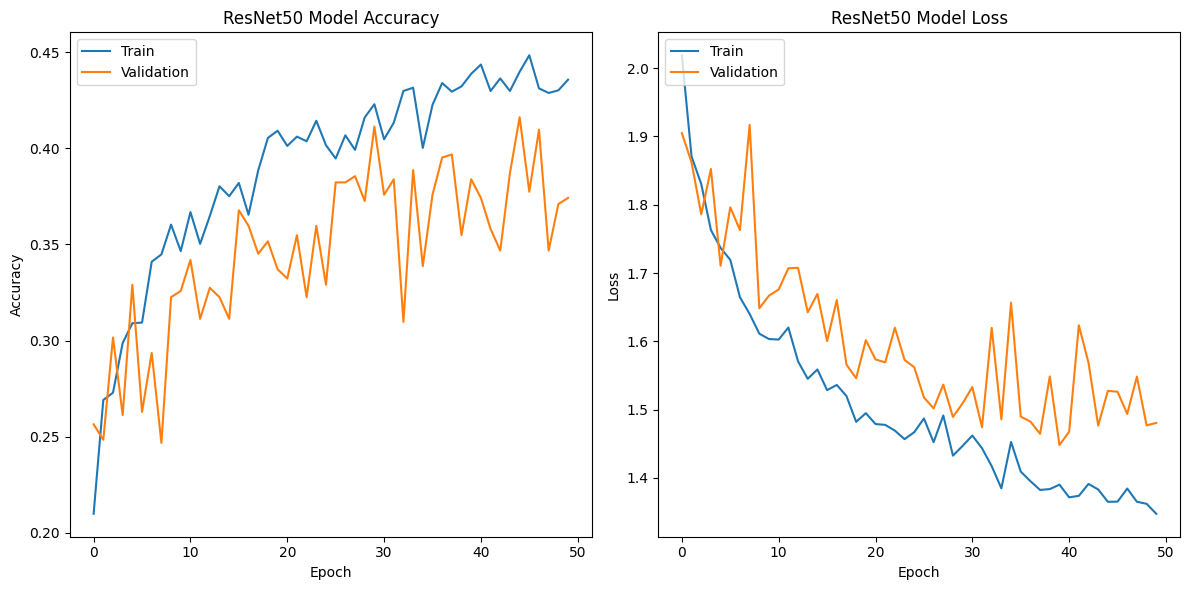

20/20 [==============================] - 4s 172ms/step
Accuracy: 0.41679873217115687
mAP: 0.40967072713041475


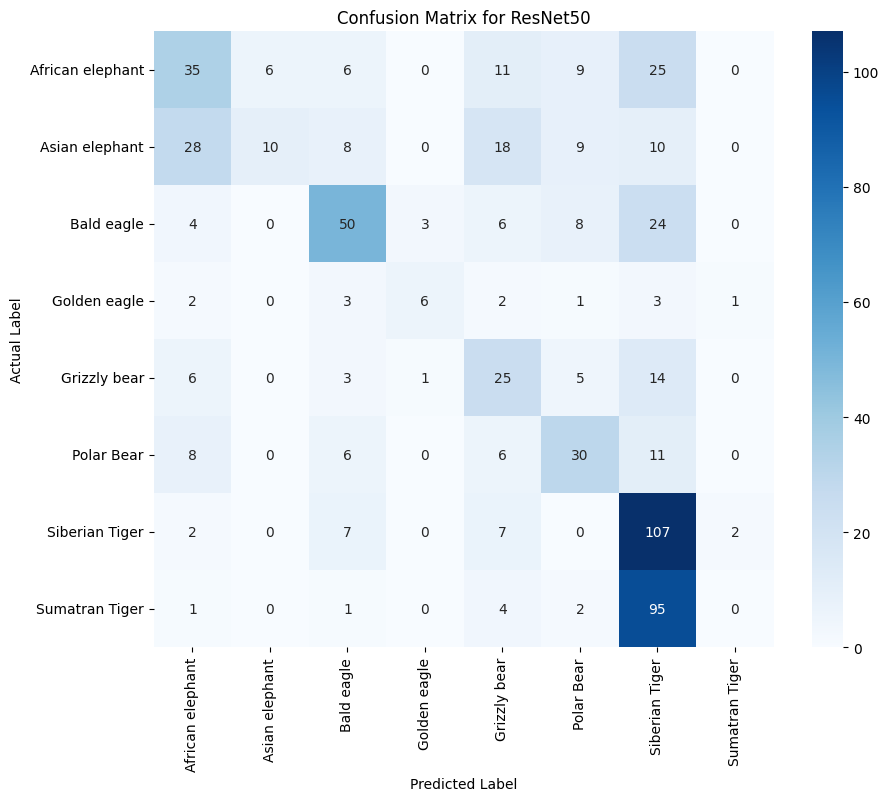

Classification Report for ResNet50
                  precision    recall  f1-score   support

African elephant       0.41      0.38      0.39        92
  Asian elephant       0.62      0.12      0.20        83
      Bald eagle       0.60      0.53      0.56        95
    Golden eagle       0.60      0.33      0.43        18
    Grizzly bear       0.32      0.46      0.38        54
      Polar Bear       0.47      0.49      0.48        61
  Siberian Tiger       0.37      0.86      0.52       125
  Sumatran Tiger       0.00      0.00      0.00       103

        accuracy                           0.42       631
       macro avg       0.42      0.40      0.37       631
    weighted avg       0.39      0.42      0.36       631



In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys(),zero_division=0))


Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.
Found 631 images belonging to 8 classes.
Class Weights: {0: 0.8567216981132075, 1: 0.9509162303664922, 2: 0.829337899543379, 3: 4.376506024096385, 4: 1.4887295081967213, 5: 1.3019713261648747, 6: 0.6273747841105354, 7: 0.7615303983228512}
Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 1.5503 - accuracy: 0.4773
Epoch 1: val_accuracy improved from -inf to 0.65323, saving model to best_resnet50_model.h5
91/91 [==============================] - 43s 440ms/step - loss: 1.5503 - accuracy: 0.4773 - val_loss: 0.6682 - val_accuracy: 0.6532
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.5564
Epoch 2: val_accuracy did not improve from 0.65323
91/91 [==============================] - 35s 385ms/step - loss: 0.8849 - accuracy: 0.5564 - val_loss: 0.6512 - val_accuracy: 0.6452
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.7568 - accura

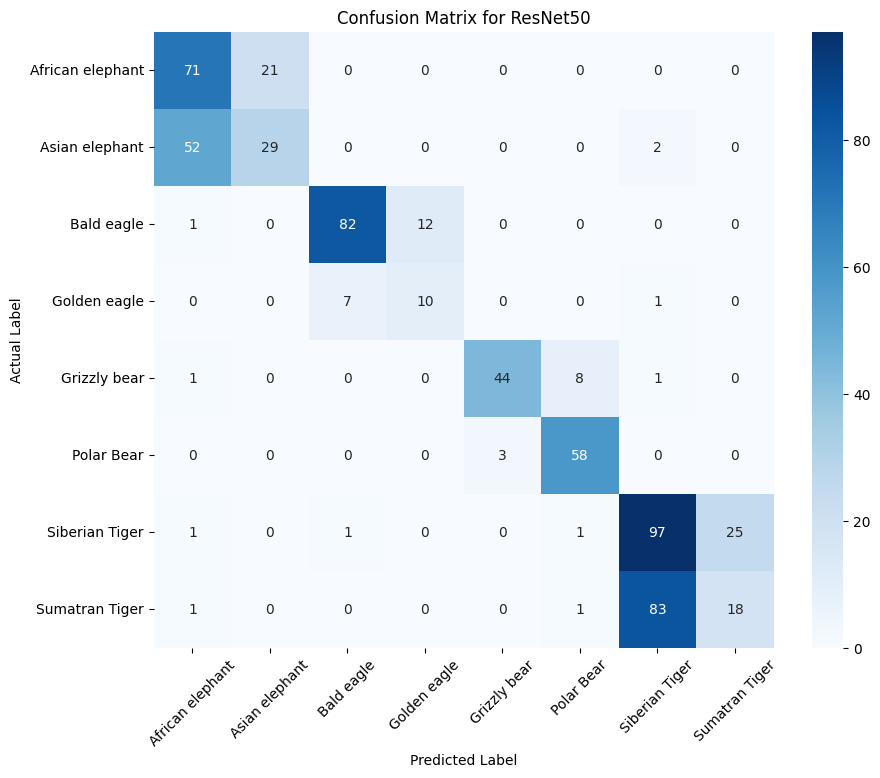

Classification Report for ResNet50
                  precision    recall  f1-score   support

African elephant       0.56      0.77      0.65        92
  Asian elephant       0.58      0.35      0.44        83
      Bald eagle       0.91      0.86      0.89        95
    Golden eagle       0.45      0.56      0.50        18
    Grizzly bear       0.94      0.81      0.87        54
      Polar Bear       0.85      0.95      0.90        61
  Siberian Tiger       0.53      0.78      0.63       125
  Sumatran Tiger       0.42      0.17      0.25       103

        accuracy                           0.65       631
       macro avg       0.65      0.66      0.64       631
    weighted avg       0.64      0.65      0.63       631



In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Maintain order for evaluation
)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with class weights
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping],
    class_weight=class_weights_dict
)
training_time = time.time() - start_time

# Unfreeze some layers in the base model for fine-tuning
for layer in base_model.layers[-100:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,  # Additional fine-tuning epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping],
    class_weight=class_weights_dict
)

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true, num_classes=len(test_generator.class_indices)), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=class_names))


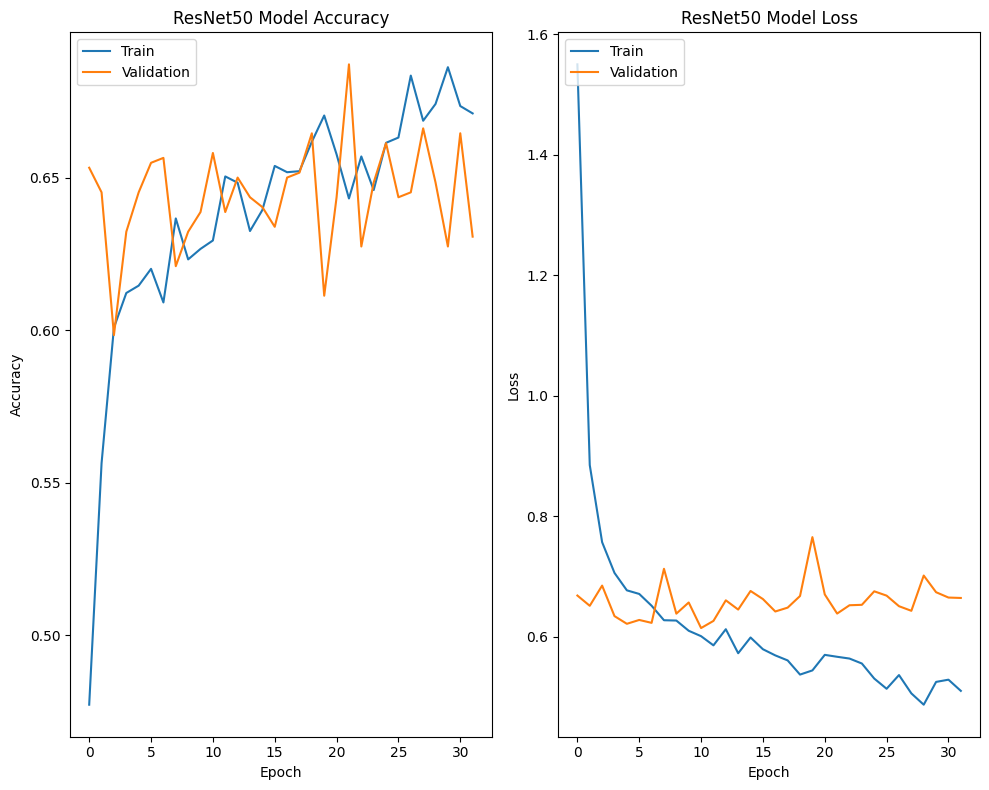

20/20 [==============================] - 4s 171ms/step
Accuracy: 0.6481774960380349
mAP: 0.6790876849906471


In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.
Found 631 images belonging to 8 classes.
Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 1.4700 - accuracy: 0.5117
Epoch 1: val_accuracy improved from -inf to 0.62903, saving model to best_resnet50_model.h5
91/91 [==============================] - 61s 647ms/step - loss: 1.4700 - accuracy: 0.5117 - val_loss: 0.6427 - val_accuracy: 0.6290
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.6077
Epoch 2: val_accuracy improved from 0.62903 to 0.65484, saving model to best_resnet50_model.h5
91/91 [==============================] - 71s 777ms/step - loss: 0.8303 - accuracy: 0.6077 - val_loss: 0.6553 - val_accuracy: 0.6548
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.6311
Epoch 3: val_accuracy improved from 0.65484 to 0.67258, saving model to best_resnet50_model.h5
91/91 [==============================] - 70s 769

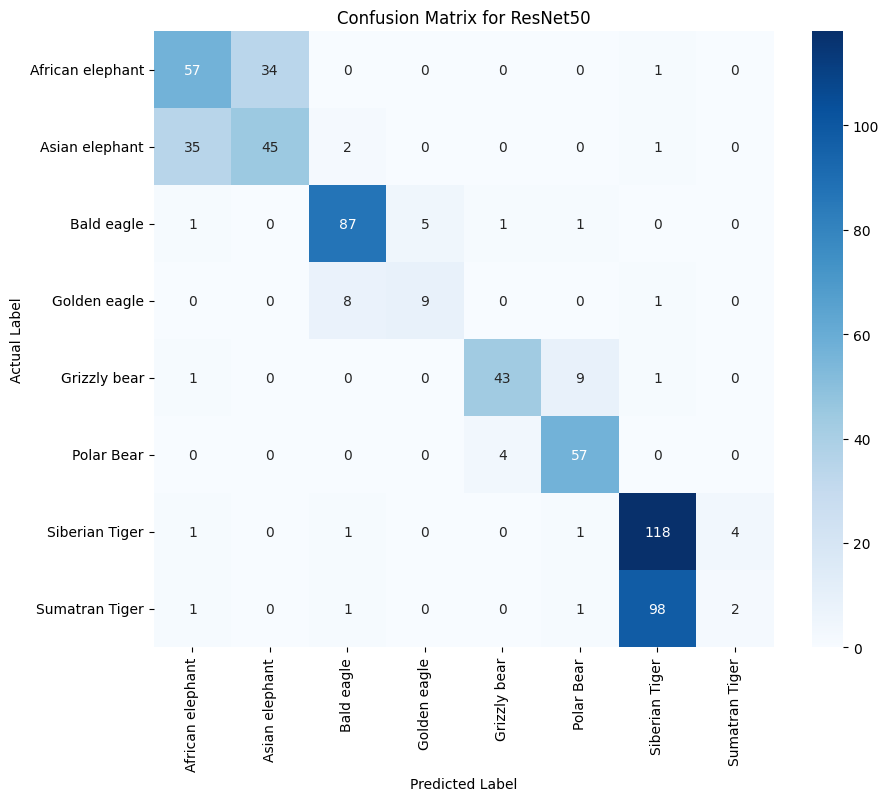

Classification Report for ResNet50
                  precision    recall  f1-score   support

African elephant       0.59      0.62      0.61        92
  Asian elephant       0.57      0.54      0.56        83
      Bald eagle       0.88      0.92      0.90        95
    Golden eagle       0.64      0.50      0.56        18
    Grizzly bear       0.90      0.80      0.84        54
      Polar Bear       0.83      0.93      0.88        61
  Siberian Tiger       0.54      0.94      0.68       125
  Sumatran Tiger       0.33      0.02      0.04       103

        accuracy                           0.66       631
       macro avg       0.66      0.66      0.63       631
    weighted avg       0.63      0.66      0.61       631



In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time


# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


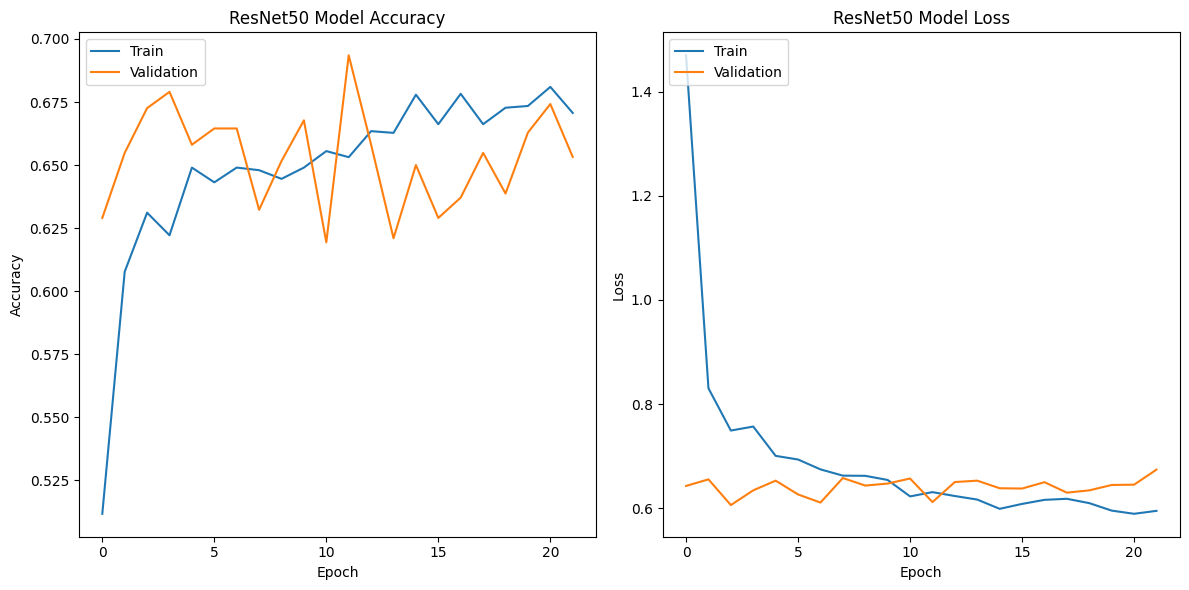

20/20 [==============================] - 6s 219ms/step
Accuracy: 0.6624405705229794
mAP: 0.6835838296381196


In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")